<a href="https://colab.research.google.com/github/Hleake117/NBA-Game-Prediction/blob/main/NBA_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

load data

In [ ]:
team_stats = pd.read_csv('/content/TeamStatistics.csv')
games = pd.read_csv('/content/Games.csv')

<ipython-input-215-4c611f9202b7>:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  games = pd.read_csv('/content/Games.csv')


prepare training set

In [ ]:
# merge the same dataset with itself on gameID
matchups = pd.merge(team_stats, team_stats, on='gameId')

In [ ]:
# Remove team-opponent duplicates by filtering to only home team rows
matchups = matchups[matchups['teamId_x'] != matchups['teamId_y']]
matchups = matchups[matchups['home_x'] == 1]

In [ ]:
# Rename columns to indicate home and away
matchups = matchups.rename(columns={
    'teamId_x': 'home_teamId',
    'teamName_x': 'home_teamName',
    'win_x': 'home_win',
    'seasonWins_x': 'home_seasonWins',
    'seasonLosses_x': 'home_seasonLosses',
    'pointsInThePaint_x': 'home_pointsInThePaint',
    'pointsFastBreak_x': 'home_pointsFastBreak',
    'pointsFromTurnovers_x': 'home_pointsFromTurnovers',
    'pointsSecondChance_x': 'home_pointsSecondChance',

    'teamId_y': 'away_teamId',
    'teamName_y': 'away_teamName',
    'seasonWins_y': 'away_seasonWins',
    'seasonLosses_y': 'away_seasonLosses',
    'pointsInThePaint_y': 'away_pointsInThePaint',
    'pointsFastBreak_y': 'away_pointsFastBreak',
    'pointsFromTurnovers_y': 'away_pointsFromTurnovers',
    'pointsSecondChance_y': 'away_pointsSecondChance',
})


select features

In [ ]:
#Feature & target
x = matchups[[
    'pointsInThePaint_x', 'pointsFastBreak_x', 'pointsFromTurnovers_x',
    'pointsSecondChance_x', 'seasonWins_x', 'seasonLosses_x',
    'pointsInThePaint_y', 'pointsFastBreak_y', 'pointsFromTurnovers_y',
    'pointsSecondChance_y', 'seasonWins_y', 'seasonLosses_y'
]]
y = matchups['win_x'] #the target variable should be 'win_x' before renaming the column

In [ ]:
#Train-test split and model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

evaluation

In [ ]:
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6198410485220301
              precision    recall  f1-score   support

           0       0.68      0.02      0.03      5498
           1       0.62      1.00      0.76      8846

    accuracy                           0.62     14344
   macro avg       0.65      0.51      0.40     14344
weighted avg       0.64      0.62      0.48     14344



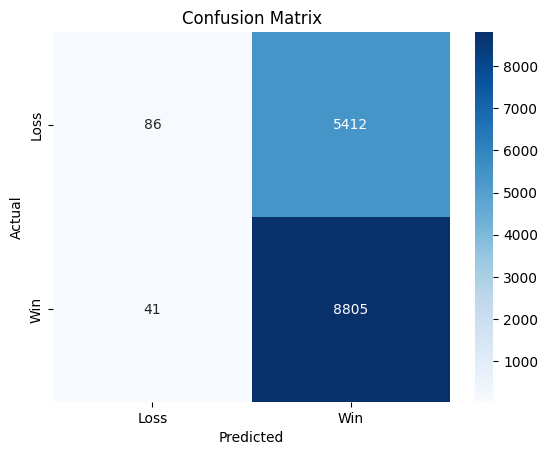

In [ ]:
conf_matrix = sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True, fmt='d', cmap='Blues',
    xticklabels=["Loss", "Win"], yticklabels=["Loss", "Win"]
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

train the model

In [ ]:
# STEP 8: Load schedule and latest stats
schedule = pd.read_csv('/content/LeagueSchedule24_25.csv')
latest_stats = team_stats.sort_values(by='gameDate').groupby('teamId').tail(1)
team_features = latest_stats.set_index('teamId').to_dict(orient='index')

In [ ]:
# STEP 9: Build future_df manually
future_rows = []

for _, row in schedule.iterrows():
    home_id = row['hometeamId']
    away_id = row['awayteamId']
    if home_id in team_features and away_id in team_features:
        h, a = team_features[home_id], team_features[away_id]
        future_rows.append({
            'gameId': row['gameId'],
            'home_teamId': home_id,
            'away_teamId': away_id,
            'home_pointsInThePaint': h.get('pointsInThePaint'),
            'home_pointsFastBreak': h.get('pointsFastBreak'),
            'home_pointsFromTurnovers': h.get('pointsFromTurnovers'),
            'home_pointsSecondChance': h.get('pointsSecondChance'),
            'home_seasonWins': h.get('seasonWins'),
            'home_seasonLosses': h.get('seasonLosses'),
            'away_pointsInThePaint': a.get('pointsInThePaint'),
            'away_pointsFastBreak': a.get('pointsFastBreak'),
            'away_pointsFromTurnovers': a.get('pointsFromTurnovers'),
            'away_pointsSecondChance': a.get('pointsSecondChance'),
            'away_seasonWins': a.get('seasonWins'),
            'away_seasonLosses': a.get('seasonLosses')
        })

future_df = pd.DataFrame(future_rows)

evaluate the model

In [ ]:
# STEP 10: Predict using actual columns
X_future = future_df.drop(columns=['gameId', 'home_teamId', 'away_teamId'])
future_df["home_win_proba"] = rf.predict_proba(X_future)[:, 1]
future_df["predicted_winner"] = future_df["home_win_proba"].apply(lambda x: "Home" if x > 0.5 else "Away")

In [ ]:
# STEP 11: Map team names and plot
team_id_to_name = latest_stats.set_index('teamId')['teamName'].to_dict()
future_df['home_team'] = future_df['home_teamId'].map(team_id_to_name)
future_df['away_team'] = future_df['away_teamId'].map(team_id_to_name)

In [ ]:
top10 = future_df.sort_values(by='home_win_proba', ascending=False).head(10)
print(top10[['home_team', 'away_team', 'home_win_proba', 'predicted_winner']])

     home_team away_team  home_win_proba predicted_winner
48     Rockets  Pelicans            0.94             Home
194   Warriors  Pelicans            0.94             Home
184   Warriors  Pelicans            0.94             Home
370      Bucks   Wizards            0.94             Home
433    Rockets  Pelicans            0.94             Home
1187    Pacers      Jazz            0.94             Home
1194    Lakers  Pelicans            0.94             Home
958     Lakers  Pelicans            0.94             Home
981    Rockets  Pelicans            0.94             Home
450      Bucks   Wizards            0.94             Home


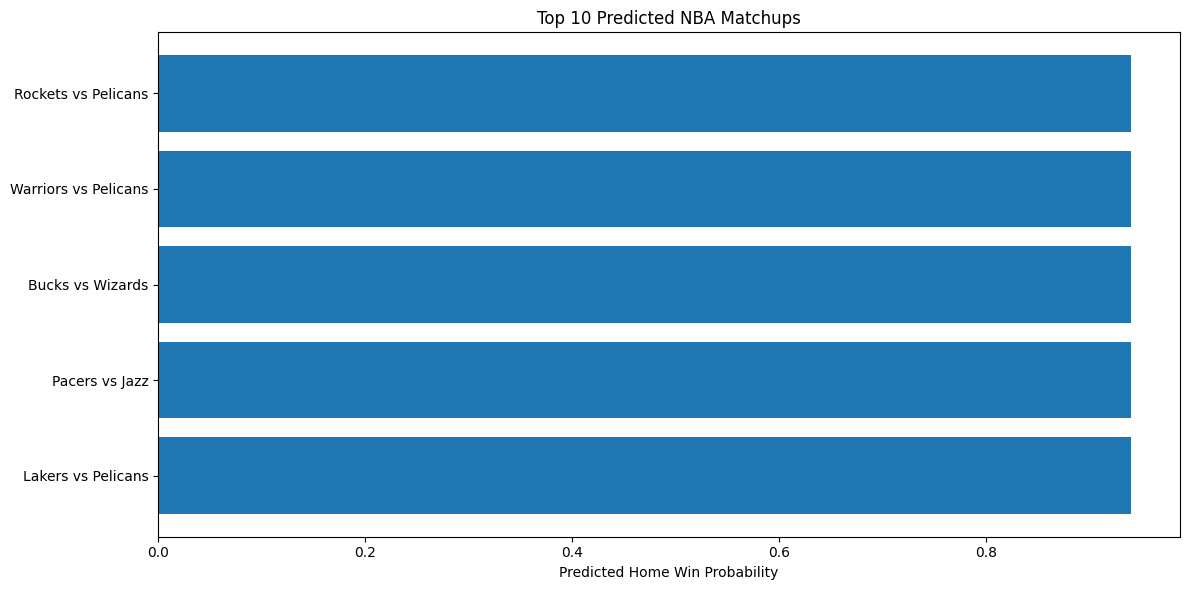

In [ ]:
plt.figure(figsize=(12, 6))
plt.barh(
    y=[f"{row['home_team']} vs {row['away_team']}" for _, row in top10.iterrows()],
    width=top10['home_win_proba']
)
plt.xlabel("Predicted Home Win Probability")
plt.title("Top 10 Predicted NBA Matchups")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# STEP 12: Save predictions
future_df[['gameId', 'home_team', 'away_team', 'home_win_proba', 'predicted_winner']].to_csv(
    '/content/NBA_Predicted_Games.csv', index=False)


In [ ]:
# STEP 13: Simulate team records
results = []
for _, row in future_df.iterrows():
    if row['predicted_winner'] == 'Home':
        results.append((row['home_team'], 'W'))
        results.append((row['away_team'], 'L'))
    else:
        results.append((row['home_team'], 'L'))
        results.append((row['away_team'], 'W'))

results_df = pd.DataFrame(results, columns=['team', 'result'])

In [ ]:
# STEP 14: Calculate standings
team_records = results_df.groupby(['team', 'result']).size().unstack(fill_value=0)
team_records['simulated_win_pct'] = team_records['W'] / (team_records['W'] + team_records['L'])
team_records = team_records.sort_values(by='simulated_win_pct', ascending=False)
print(team_records)

result          L   W  simulated_win_pct
team                                    
Knicks          5  82           0.942529
Rockets         8  78           0.906977
Pacers         15  71           0.825581
Thunder        16  70           0.813953
Clippers       17  70           0.804598
Bucks          17  69           0.802326
Warriors       19  69           0.784091
Pistons        20  67           0.770115
Cavaliers      23  63           0.732558
Trail Blazers  24  61           0.717647
Grizzlies      25  62           0.712644
Lakers         26  62           0.704545
Nuggets        33  54           0.620690
Magic          42  43           0.505882
76ers          44  43           0.494253
Heat           46  41           0.471264
Kings          46  41           0.471264
Raptors        48  39           0.448276
Celtics        48  39           0.448276
Bulls          51  36           0.413793
Timberwolves   59  28           0.321839
Mavericks      59  27           0.313953
Nets           6

In [ ]:
# STEP 15: Save standings
team_records.to_csv('/content/NBA_Simulated_Standings.csv')
print("✅ Files saved:\n- NBA_Predicted_Games.csv\n- NBA_Simulated_Standings.csv")

✅ Files saved:
- NBA_Predicted_Games.csv
- NBA_Simulated_Standings.csv
